In [52]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation

In [105]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signals(signals, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 12)
    plt.imshow(signals, cmap='jet')
    plt.title(title)

In [2]:
raw_data = open('sar_data/sample/sample.dat', 'rb')

In [3]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(raw_data)
    swath_packets = []
    while (raw_data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append(packet)
        except ValueError as ve:
            break
    return swath_packets      

In [4]:
swath_packets = get_packets_in_swath(raw_data, 10)

In [5]:
def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append(packet)
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

In [6]:
burst = get_packets_in_burst(swath_packets, 5)

In [7]:
def decode_signals(packets):
    signals = []
    index = 0
    for packet in packets:
        if index % 250 == 0:
            print(f"{index} of {len(packets)}")
        signals.append(packet.get_complex_samples())
        index += 1
    return np.asarray(signals)

In [47]:
do_decode = False
save_decode = False
load_signals = False

if do_decode:
    signals = decode_signals(burst)
    if save_decode:
        np.save("burst_iw1_5.npy", signals)
if load_signals:
    signals = np.load("burst_iw1_5.npy")

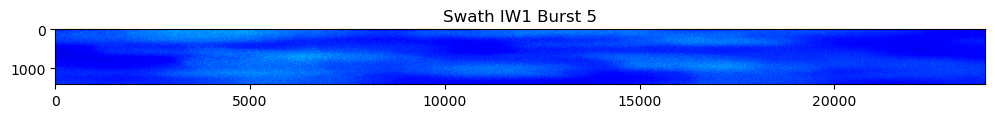

In [106]:
plot_signals(np.abs(signals) / np.max(np.abs(signals)), title="Swath IW1 Burst 5")

In [42]:
range_decimation_list = [
    112.6041667,
    100.0925926,
    0.000000000,
    83.41049387,
    66.72839509,
    56.30208336,
    50.04629632,
    25.02314816,
    64.34523813,
    46.91840280,
    17.32371796,
    54.59595962
]

def get_replica_chirps(packets):
    replica_chirps = []
    for packet in packets:
        secondary_header = packet.get_secondary_header()
        range_decimation = secondary_header['range_decimation']
        txpsf = secondary_header['tx_pulse_start_frequency']
        txprr = secondary_header['tx_ramp_rate']
        txpl  = secondary_header['pulse_length']
        phi_1 = txpsf - (txprr * (-txpl / 2))
        phi_2 = txprr / 2
        fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
        t = np.linspace(-0.5 * txpl, (0.5 * txpl), fs)
        chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
        replica_chirps.append(chirp)
    return np.asarray(replica_chirps)

In [43]:
replica_chirps = get_replica_chirps(burst)

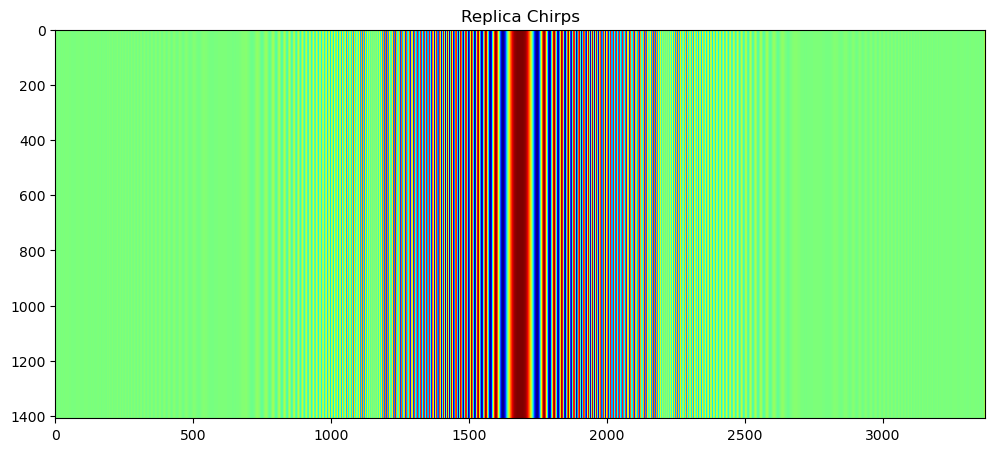

In [94]:
plot_signals(replica_chirps.real, title="Replica Chirps")

In [59]:
def get_reference_function(replica):
    num_samples = replica.shape[0]
    window = np.hanning(num_samples)
    reference = np.conj(replica) * window
    norm = np.abs(reference)
    energy = 0.0
    for i in range(num_samples):
        energy += (norm[i] * norm[i])
    energy /= num_samples
    for i in range(num_samples):
        reference[i] = reference[i] / energy
    return np.asarray(reference)

def pulse_compression(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_func = get_reference_function(replica)
    num_samples = f_chirp.shape[0]
    ref_func_samples = ref_func.shape[0]
    ref_func_padded = []
    for i in range(num_samples):
        if i < ref_func_samples:
            ref_func_padded.append(ref_func[i])
        else:
            ref_func_padded.append(0.0)
    f_ref_func = fft(ref_func_padded)
    for i in range(num_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifft(np.asarray(pulse_compressed))

In [64]:
pulse_compressed_signal = pulse_compression(signals[0], replica_chirps[0])

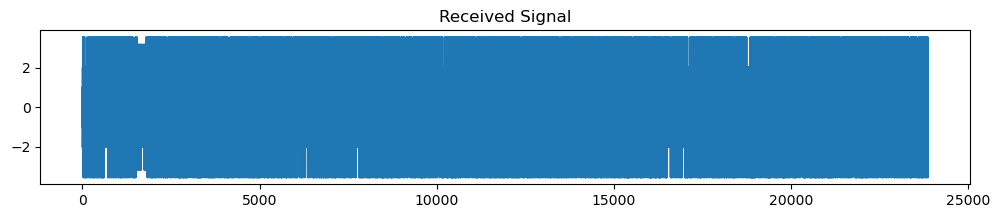

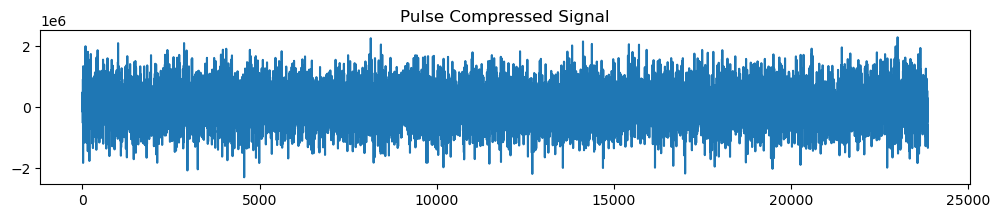

In [99]:
plot_signal(signals[0].real, title="Received Signal")
plot_signal(pulse_compressed_signal.real, title="Pulse Compressed Signal")

In [100]:
def range_compress_burst(signals, replica_chirps):
    num_packets = signals.shape[0]
    range_compressed_signals = np.zeros_like(signals)
    for i in range(num_packets):
        range_compressed_signals[i] = pulse_compression(signals[i], replica_chirps[i])
    return range_compressed_signals

In [101]:
range_compressed_burst = range_compress_burst(signals, replica_chirps)

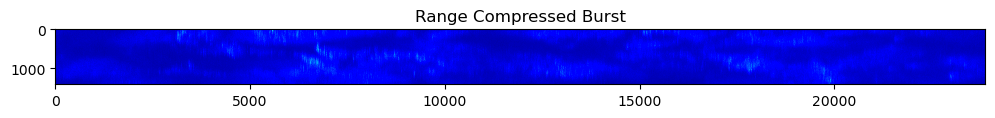

In [104]:
plot_signals(np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst)), title="Range Compressed Burst")

In [107]:
range_doppler_burst = fft(range_compressed_burst, axis=0)

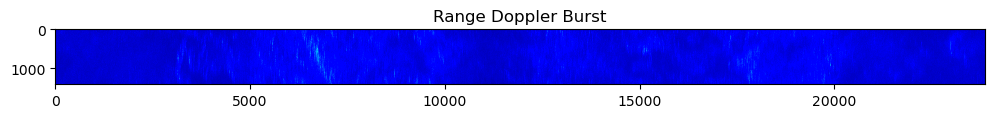

In [108]:
plot_signals(np.abs(range_doppler_burst) / np.max(np.abs(range_doppler_burst)), title="Range Doppler Burst")